In [1]:
# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose


#  import statsmodels.graphics.tsaplots.plot_acf and statsmodels.graphics.tsaplots.plot_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# import shapiro from scipy.stats
from scipy.stats import shapiro

# use qqplot from statsmodels.graphics.gofplots
from statsmodels.graphics.gofplots import qqplot

from scipy.signal import periodogram
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


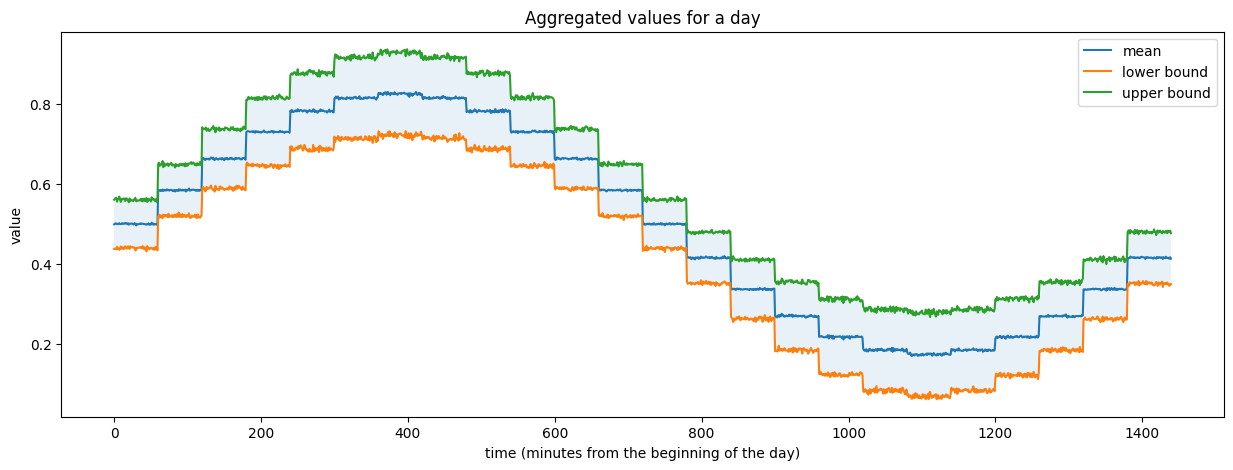

In [2]:
# create a panda dataframe with datetime column and a value column with values every minute of 2022 year and values that are randomly fluctuating between 0 and 1 with daily seasonality


# create a panda dataframe with datetime column and a value column with values every minute of 2022 year and values that are randomly fluctuating between 0 and 1 with daily seasonality
def create_df():
    # create a list of datetime objects
    start = datetime.datetime(2022, 1, 1, 0, 0)
    end = datetime.datetime(2022, 12, 31, 23, 59)
    step = datetime.timedelta(minutes=1)
    result = []
    while start <= end:
        result.append(start)
        start += step
    # create a dataframe with datetime column and a value column
    df = pd.DataFrame(result, columns=['datetime'])
    # add daily seasonality and make the values lower at midnight and higher at noon as a sin function and make data variance higher at midday
    df['value'] = np.sin(df['datetime'].dt.hour * 2 * np.pi / 24)
    # add a random noise to the values that is higher at midday
    df['value'] = df['value'] + np.random.normal(0, 0.1, size=len(df)) * np.sin(df['datetime'].dt.hour * 2 * np.pi / 24)
    # add a random trend changind every 40 days
    df['value'] = df['value'] + np.random.normal(0, 0.1, size=len(df)) * np.sin(df['datetime'].dt.day * 2 * np.pi / 40)
    # normalize the values to be between 0 and 1
    df['value'] = (df['value'] - df['value'].min()) / (df['value'].max() - df['value'].min())
    return df

df = create_df()
df.head()

# create a class that will calculate the aggregated (mean value, std, lower and upper bounds of a 99% quantile) values for a given time window (day, week, month)

class AggTsCals():
    def __init__(self, ts:pd.Series) -> None:
        """initialize

        Args:
            ts (pd.Series): временной ряд для анализа
        """        
        self.ts = ts
        self.stl_decomposition_results = None

    def __str__(self) -> str:
        return str(self.ts)

    def agg_by_day(self):
        """group by minute and hour inside a day and calculate the aggregated (mean value, std, lower and upper bounds of a 99% quantile) values for each minute and hour
        """        
        df = self.ts.copy()
        df['hour'] = df['datetime'].dt.hour
        df['minute'] = df['datetime'].dt.minute
        df_agg = df.groupby(['hour', 'minute'])['value'].agg(['mean', 'std'])
        # estimate the quatiles of the empirical distribution of the mean values
        df_agg['lower_bound'] = df_agg['mean'] - 2.58 * df_agg['std']
        df_agg['upper_bound'] = df_agg['mean'] + 2.58 * df_agg['std']
        return df_agg

    def plot_results(self, df:pd.DataFrame, title:str, x_label:str, y_label:str, figsize:tuple=(15, 5)) -> None:
        """plot the results

        Args:
            df (pd.DataFrame): aggregated values for a given time window
            title (str): plot title
            x_label (str): x axis label
            y_label (str): y axis label
            figsize (tuple, optional): plot size. Defaults to (15, 5).
        """        
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        # solve the error ValueError: setting an array element with a sequence.
        df['hour'] = df.index.get_level_values('hour')
        df['minute'] = df.index.get_level_values('minute')
        # create a time column that is a numeric value of minutes from the beginning of the day
        df['time'] = df['hour'] * 60 + df['minute']
        # plot the results
        sns.lineplot(data=df, x='time', y='mean', ax=ax, label='mean')
        sns.lineplot(data=df, x='time', y='lower_bound', ax=ax, label='lower bound')
        sns.lineplot(data=df, x='time', y='upper_bound', ax=ax, label='upper bound')
        # color the area between the lower and upper bounds with low transparency
        ax.fill_between(df['time'], df['lower_bound'], df['upper_bound'], alpha=0.1)
        plt.show()

    # add a method that will test how stable the seasonality for a window of one day
    def test_seasonality_stability(self, df:pd.DataFrame, window_size:int, figsize:tuple=(15, 5)) -> None:
        """test how stable the seasonality for a window of one day

        Args:
            df (pd.DataFrame): aggregated values for a given time window
            window_size (int): window size in minutes
            figsize (tuple, optional): plot size. Defaults to (15, 5).
        """        
        # create a time column that is a numeric value of minutes from the beginning of the day
        df['time'] = df.index.get_level_values('hour') * 60 + df.index.get_level_values('minute')
        # create a column with the number of the window
        df['window'] = df['time'] // window_size
        # calculate the aggregated (mean value, std, lower and upper bounds of a 99% quantile) values for each window
        df_agg = df.groupby('window')['mean', 'lower_bound', 'upper_bound'].agg(['mean', 'std'])
        # plot the results
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title('Aggregated values for a day')
        ax.set_xlabel('time (minutes from the beginning of the day)')
        ax.set_ylabel('value')
        # fix error ValueError: Data must be 1-dimensional
        df_agg = df_agg.reset_index()
        # plot the results
        sns.lineplot(data=df_agg, x='window', y='mean', ax=ax, label='mean')
        sns.lineplot(data=df_agg, x='window', y='lower_bound', ax=ax, label='lower bound')
        sns.lineplot(data=df_agg, x='window', y='upper_bound', ax=ax, label='upper bound')
        # color the area between the lower and upper bounds with low transparency
        ax.fill_between(df_agg['window'], df_agg['lower_bound'], df_agg['upper_bound'], alpha=0.1)
        plt.show()

    # add a method that applies an stl decomposition with dayly, weekly and monthly seasonality to the time series that removes the trend from the time series
    def stl_decomposition(self, figsize:tuple=(15, 5)) -> None:
        """apply an stl decomposition with dayly, weekly and monthly seasonality to the time series that removes the trend from the time series

        Args:
            figsize (tuple, optional): plot size. Defaults to (15, 5).
        """        
        # use self.ts
        # apply an stl decomposition with dayly, weekly and monthly seasonality to the time series that removes the trend from the time series
        result = seasonal_decompose(self.ts['value'], model='additive', period=1440*7)
        # plot the results on different subplots stacked vertically
        _, axes = plt.subplots(4, 1, figsize=figsize)
        result.observed.plot(ax=axes[0], legend=False)
        axes[0].set_ylabel('Observed')
        result.trend.plot(ax=axes[1], legend=False)
        axes[1].set_ylabel('Trend')
        result.seasonal.plot(ax=axes[2], legend=False)
        axes[2].set_ylabel('Seasonal')
        result.resid.plot(ax=axes[3], legend=False)
        axes[3].set_ylabel('Residual')
        plt.show()

        # return the results of the stl decomposition
        # write results into stl_decomposition_results attribute
        self.stl_decomposition_results = result
        return result
    

    
    # add a method to check pacf and acf plots of the residuals from self.stl_decomposition_results
    def check_residuals(self, figsize:tuple=(15, 5)) -> None:
        """check pacf and acf plots of the residuals from self.stl_decomposition_results

        Args:
            figsize (tuple, optional): plot size. Defaults to (15, 5).
        """        
        # use self.stl_decomposition_results
        # plot the pacf and acf plots of the residuals
        # check if self.stl_decomposition_results is not None
        if self.stl_decomposition_results is None:
            raise ValueError('self.stl_decomposition_results is None. Run self.stl_decomposition() first.')
        # drop na values
        decomposed_nona = self.stl_decomposition_results.resid.dropna()
        # plot the pacf and acf plots of the residuals
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        # use pacf and acf plots from statsmodels to plot the pacf and acf plots of the residuals
        plot_pacf(decomposed_nona, ax=axes[0])
        plot_acf(decomposed_nona, ax=axes[1])
        plt.show()

    # add a method to check if the residuals are normally distributed, using the shapiro test
    def check_residuals_normality(self) -> None:
        """check if the residuals are normally distributed, using the shapiro test

        """        
        # use self.stl_decomposition_results
        # check if self.stl_decomposition_results is not None
        if self.stl_decomposition_results is None:
            raise ValueError('self.stl_decomposition_results is None. Run self.stl_decomposition() first.')
        # drop na values
        decomposed_nona = self.stl_decomposition_results.resid.dropna()
        # check if the residuals are normally distributed, using the shapiro test
        # use the shapiro test from scipy.stats
        stat, p = shapiro(decomposed_nona)
        # print the results
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('Sample does not look Gaussian (reject H0)')
        # plot the results

        sns.displot(decomposed_nona)
        plt.show()

        # plot qq plot
        # use qqplot from statsmodels.graphics.gofplots
        qqplot(decomposed_nona, line='s')
        plt.show()

    # add a class methord to ckeck the periodogram same as check_periodogram function
    @classmethod
    def check_periodogram(cls, df, title):
        """check periodogram of the residuals

        """        
        f, ppx = periodogram(df.dropna())

        result_list = list(sorted(zip(f, ppx), key=lambda x: x[1]))[-50:]
        # plot the result_list with first term being inverse of the frequency and second term being the power
        plt.plot([1/x[0] for x in result_list], [x[1] for x in result_list])
        # add x and y labels
        # add plot title
        plt.title(title)
        plt.xlabel('Period')
        plt.ylabel('Power')
        plt.show()

    
    # add a method to check the periodogram of the residuals
    def check_periodogram_residuals(self):
        """check the periodogram of the residuals

        """        
        # use self.stl_decomposition_results
        # check if self.stl_decomposition_results is not None
        if self.stl_decomposition_results is None:
            raise ValueError('self.stl_decomposition_results is None. Run self.stl_decomposition() first.')
        # drop na values
        decomposed_nona = self.stl_decomposition_results.resid.dropna()
        # check the periodogram of the residuals
        self.check_periodogram(decomposed_nona, 'Periodogram of the residuals')

    # add a method to check the periodogram of the time series
    def check_periodogram_ts(self):
        """check the periodogram of the time series

        """        
        # use self.ts
        # check the periodogram of the time series
        self.check_periodogram(self.ts['value'], 'Periodogram of the time series')



    




# create an instance of the class
agg_ts = AggTsCals(df)

# calculate the aggregated (mean value, std, lower and upper bounds of a 99% quantile) values for a given time window (day)
df_agg_by_day = agg_ts.agg_by_day()

# plot the results
agg_ts.plot_results(df_agg_by_day, 'Aggregated values for a day', 'time (minutes from the beginning of the day)', 'value')




In [3]:
df_agg_by_day = agg_ts.agg_by_day()
df_agg_by_day.head()


mean       std  lower_bound  upper_bound
hour minute                                              
0    0       0.499142  0.023870     0.437559     0.560726
     1       0.500432  0.023928     0.438697     0.562167
     2       0.501729  0.024516     0.438479     0.564980
     3       0.501155  0.024979     0.436708     0.565602
     4       0.499438  0.021850     0.443065     0.555810

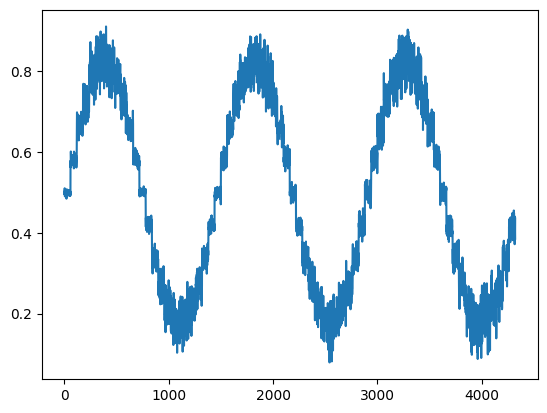

In [4]:
# plot df.values
plt.plot(df.value[:1440*3])
plt.show()

<Axes: xlabel='hour,minute'>

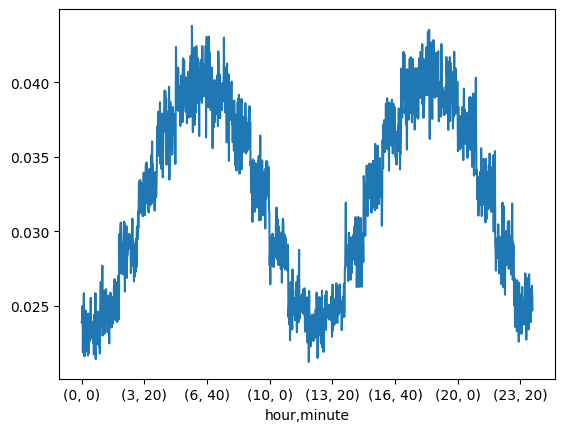

In [5]:
# plot std values from df_agg_by_day
df_agg_by_day['std'].plot()

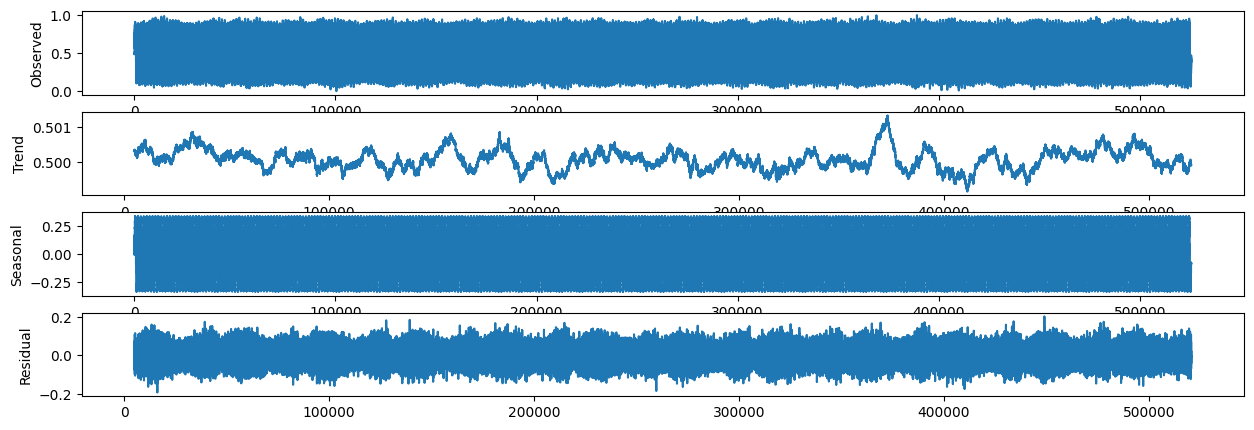

In [6]:
# use stl_decomposition method to remove trend from the time series
agg_ts.stl_decomposition()

e:\code\ts_march_2023\venv\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=0.996, p=0.000
Sample does not look Gaussian (reject H0)


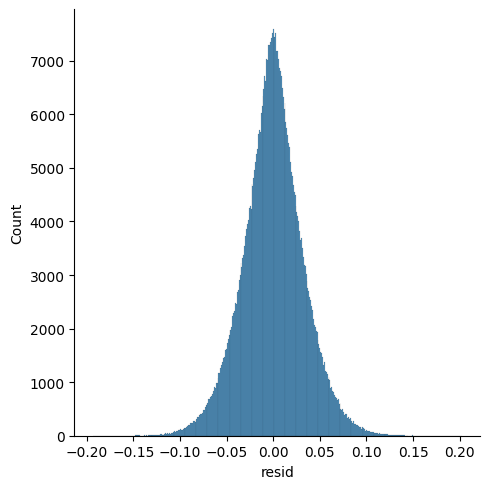

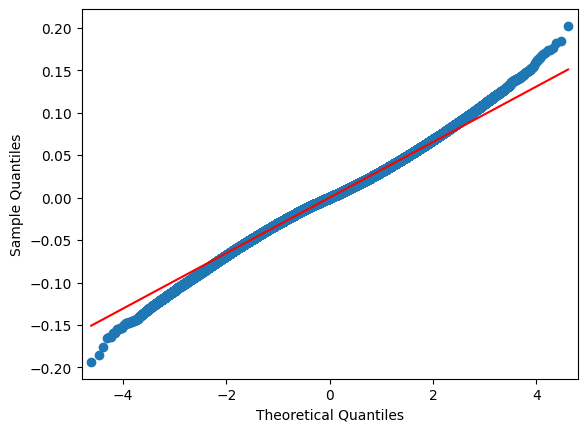

In [7]:
# check if the residuals are normally distributed, using the shapiro test
agg_ts.check_residuals_normality()

e:\code\ts_march_2023\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


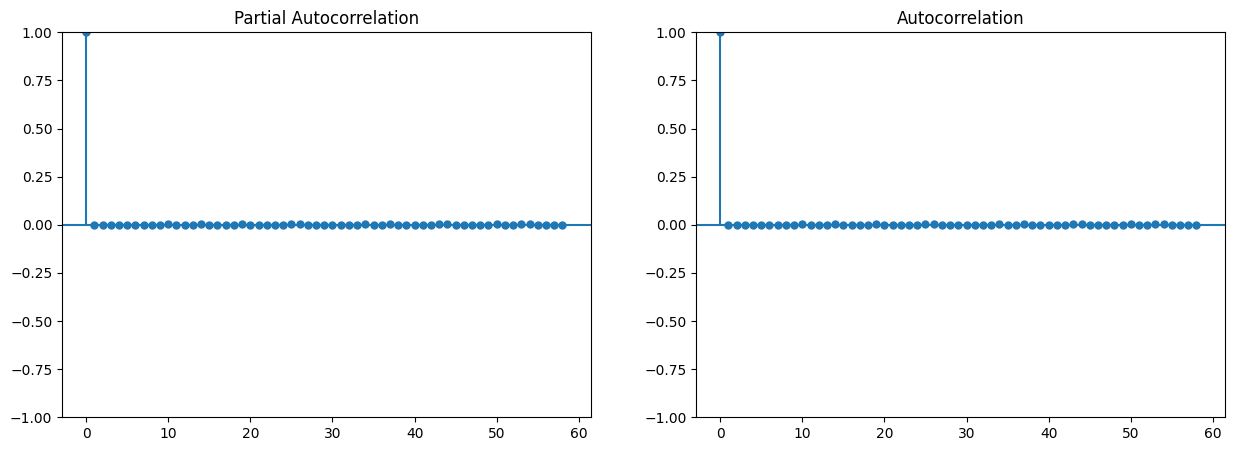

In [8]:
# check_residuals
agg_ts.check_residuals()

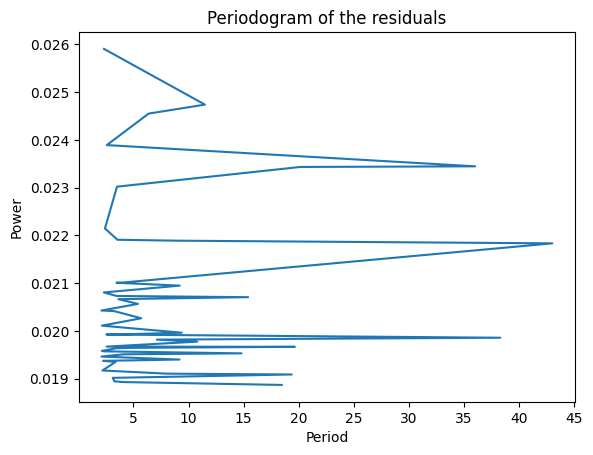

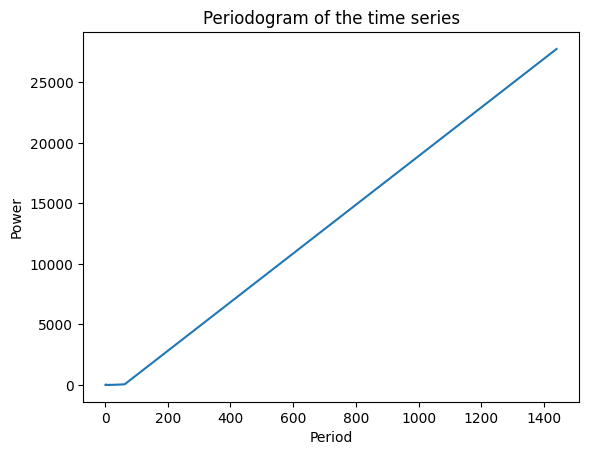

In [9]:

# check the periodogram of the residuals and the time series
agg_ts.check_periodogram_residuals()
agg_ts.check_periodogram_ts()


In [11]:
        ts = pd.Series([1,2,3])
        exemplai = AggTsCals(ts)


In [12]:
str(exemplai)

'0    1\n1    2\n2    3\ndtype: int64'